In [2]:
# user defined functions

import odor_statistics_lib as osm

# dataframes
import pandas as pd

#suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.TimeSeries = pd.Series 

#math
import numpy as np
import math
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import fft

import multiprocessing as mp


#plots
import string
import figurefirst
from figurefirst import FigureLayout,mpl_functions
import pylab as plt
import matplotlib.pyplot as plt

from mpl_toolkits.axes_grid1 import make_axes_locatable # for colorbar
import seaborn as sns
sns.set()
sns.set_style("whitegrid")
pd.options.mode.chained_assignment = None

In [3]:
def fft_of_data(data,dt):
    data = data-np.mean(data)
    N = data.shape[0] # Length of data.
    try:
        yf = 2.0/N * (fft.fft(data)[0:N//2])
    except ZeroDivisionError:
        yf= 0

    xf = fft.fftfreq(N,dt)[:N//2]# Only take the first half of the data.

    return(xf, yf) # xf = frequency array. yf = amplitude or power.


In [4]:
# def calculate_unit_vector(point):
#     norm = np.linalg.norm(point)
#     return point / norm if norm != 0 else point

# def calculate_vector_components(v, u):
#     u_norm = u / np.linalg.norm(u)
#     v_dot_u = np.dot(v, u_norm)
#     v_parallel = v_dot_u * u_norm
#     v_perpendicular = v - v_parallel
#     return v_parallel, v_perpendicular

def calculate_rotation_matrix(angle):
    c, s = np.cos(angle), np.sin(angle)
    return np.array([[c, -s], [s, c]])

def rotate_vector(vector, rotation_matrix):
    return np.dot(rotation_matrix, vector)

In [5]:
dir = '~/DataAnalysis/data/Sprints/HighRes/'

In [6]:
df1 = pd.read_hdf(dir+'Windy/WindyMASigned.h5')
df2 = pd.read_hdf(dir+'NotWindy/NotWindyMASigned.h5')
df3 = pd.read_hdf(dir+'Forest/ForestMASigned.h5')


In [7]:
# df=pd.concat([df1,df2,df3])
# df.reset_index(inplace=True, drop=True)

### Vector projection Anaylsis

In [8]:
# dat=pd.DataFrame()
# dat=df3
# points = dat[['xsrc', 'ysrc']].values
# velocities = dat[['gps_linear_x', 'gps_linear_y']].values

# unit_vectors = np.apply_along_axis(calculate_unit_vector, 1, points)
# parallels = []
# perpendiculars = []

# for v, u in zip(velocities, unit_vectors):
#     v_parallel, v_perpendicular = calculate_vector_components(v, u)
#     parallels.append(v_parallel)
#     perpendiculars.append(v_perpendicular)

# # Convert the results to numpy arrays for easier handling
# parallels = np.array(parallels)
# perpendiculars = np.array(perpendiculars)

# # Add the results to the DataFrame
# dat['unit_x'], dat['unit_y'] = unit_vectors[:, 0], unit_vectors[:, 1]
# dat['parallel_x'], dat['parallel_y'] = parallels[:, 0], parallels[:, 1]
# dat['perpendicular_x'], dat['perpendicular_y'] = perpendiculars[:, 0], perpendiculars[:, 1]

In [13]:
dat = pd.DataFrame() # Replace this with your actual data
dat=df3
heading='Forest'
# Your specific points and velocities
points = dat[['xsrc', 'ysrc']].values
velocities = dat[['gps_linear_x', 'gps_linear_y']].values

# Calculate the rotation angle for each point
angles = np.arctan2(points[:, 1], points[:, 0])

rotated_velocities = []

# Rotate each velocity to the body-fixed frame
for angle, velocity in zip(angles, velocities):
    rotation_matrix = calculate_rotation_matrix(angle)
    rotated_velocity = rotate_vector(velocity, rotation_matrix)
    rotated_velocities.append(rotated_velocity)

# Convert the list of rotated velocities to a numpy array
rotated_velocities = np.array(rotated_velocities)

# Extract the components of the velocities in the body-fixed frame
parallel_components = rotated_velocities[:, 0]
perpendicular_components = rotated_velocities[:, 1]

# Add the results to the DataFrame
dat['parallel'] = parallel_components
dat['perpendicular'] = perpendicular_components


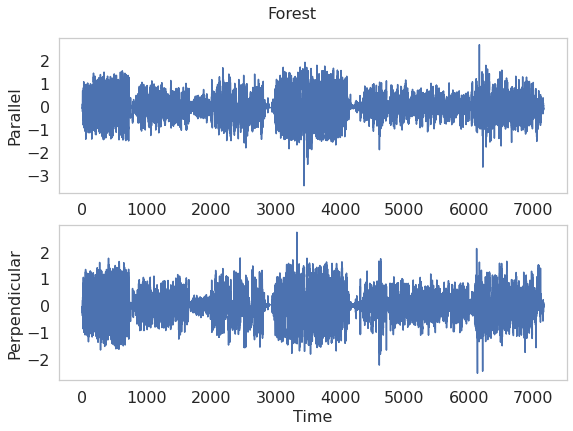

In [14]:
fig, axs = plt.subplots(2, 1, figsize=(8, 6))

# Plot parallel_x
axs[0].plot(dat.time, dat.parallel)
axs[0].set_ylabel('Parallel')
axs[0].grid(False)

# Plot parallel_y
axs[1].plot(dat.time, dat.perpendicular)
axs[1].set_ylabel('Perpendicular')
axs[1].grid(False)

# Set common x-axis label
axs[-1].set_xlabel('Time')

fig.suptitle(heading)
fig.tight_layout()
figurefirst.mpl_functions.set_fontsize(fig, 16)
# fig.savefig('../../Figure/timeseriesforest.jpeg', dpi=300, bbox_inches = "tight")

In [15]:
dt = dat.time[1] - dat.time[0]

f_parallel, parallel_fft = fft_of_data(np.array(dat.parallel), dt)
f_perpendicular, perpendicular_fft = fft_of_data(np.array(dat.perpendicular), dt)

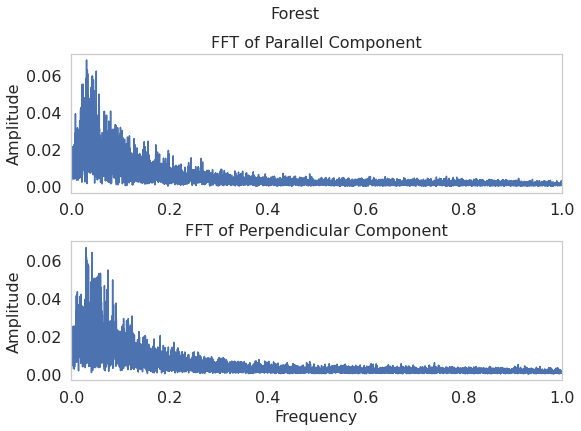

In [16]:
# Plot the FFT results for parallel components
f, axs = plt.subplots(2, 1, figsize=(8, 6))

axs[0].plot(f_parallel, np.abs(parallel_fft))
axs[0].set_ylabel('Amplitude')
axs[0].set_title('FFT of Parallel Component')
axs[0].grid(False)

axs[1].plot(f_perpendicular, np.abs(perpendicular_fft))
axs[1].set_xlabel('Frequency')
axs[1].set_ylabel('Amplitude')
axs[1].set_title('FFT of Perpendicular Component')
axs[1].grid(False)

axs[0].set_xlim(0, 1)
axs[1].set_xlim(0, 1)

f.suptitle(heading)
f.tight_layout()
figurefirst.mpl_functions.set_fontsize(f, 16)
# f.savefig('../../Figure/Parallelforest.jpeg', dpi=300, bbox_inches="tight")

/tmp/ipykernel_122687/4172921095.py:3: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(f_parallel), np.log10(parallel_fft), label='parallel')
/home/gadfly/DataAnalysis/pyresearch/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/tmp/ipykernel_122687/4172921095.py:4: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(f_perpendicular), np.log10(perpendicular_fft), label='perpendicular', alpha=0.6)
/home/gadfly/DataAnalysis/pyresearch/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


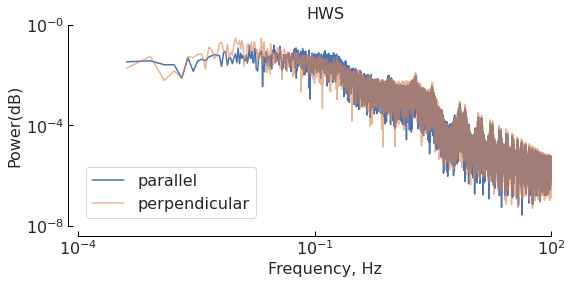

In [85]:
f,ax = plt.subplots(1,1, figsize=(8,4))

ax.plot(np.log10(f_parallel), np.log10(parallel_fft), label='parallel')
ax.plot(np.log10(f_perpendicular), np.log10(perpendicular_fft), label='perpendicular', alpha=0.6)

ax.set_xlabel('Frequency, Hz')
ax.set_ylabel('Power(dB)')
ax.grid(False)

mpl_functions.adjust_spines(ax,['left', 'bottom'],spine_locations={},
                            smart_bounds=True, xticks=[-4,-1,2],yticks=[-8,-4,0],linewidth=1)
ax.set_xticklabels([r'$10^{-4}$',r'$10^{-1}$', r'$10^{2}$'])
ax.set_yticklabels([r'$10^{-8}$',r'$10^{-4}$', r'$10^{-0}$'])

ax.legend(loc='lower left', fontsize=16)
    
ax.set_title(heading)

f.tight_layout(pad=1)
figurefirst.mpl_functions.set_fontsize(f, 16)


# f.savefig('../../Figure/hws1.jpeg', dpi=300, bbox_inches = "tight")

### Distribution of where we walked relative to the source

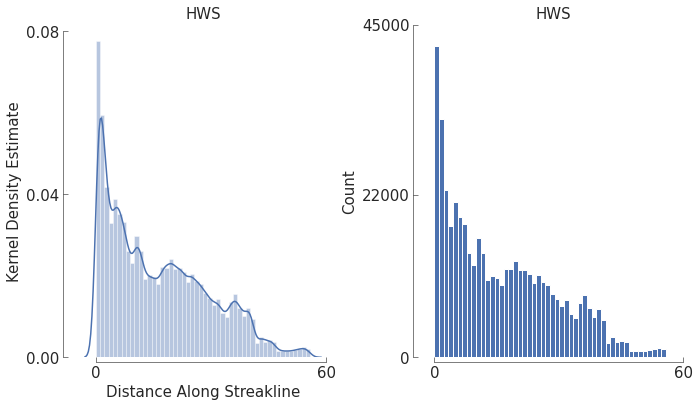

In [71]:
f,(ax1,ax2)=plt.subplots(1,2,figsize=(10,6))
sns.distplot(df1.distance_from_source_a*df1.xsign, bins=50, kde=True, norm_hist=True, ax=ax1)
ax1.set_xlabel('Distance Along Streakline')
ax1.set_ylabel('Kernel Density Estimate')
ax1.grid(False)

ax1.set_title('HWS')
mpl_functions.adjust_spines(ax1,['left','bottom'],spine_locations={'bottom': 5}, 
                            smart_bounds=True, 
                            xticks=[0,60],
                            yticks=[0,0.04,0.08],
                            linewidth=0.5)

ax2.hist(df1.distance_from_source_a*df1.xsign, bins=50)
ax2.grid(False)
ax2.set_title('HWS')
ax2.set_ylabel('Count')
mpl_functions.adjust_spines(ax2,['left','bottom'],spine_locations={'bottom': 5}, 
                            smart_bounds=True, 
                            xticks=[0,60],
                            yticks=[0,22000,45000],
                            linewidth=0.5)
f.tight_layout(pad=2)
figurefirst.mpl_functions.set_fontsize(f, 15)
# f.savefig('../../Figure/hist_1.jpeg', dpi=300, bbox_inches = "tight")

In [ ]:
# # Initialize two empty lists for r_dot and theta_dot
# r_list = []
# theta_list = []
# r_dot_list = []
# theta_dot_list = []

# # Loop over each row in the DataFrame
# for i in range(len(df1)):
#     # Call the function and store the results
#     r, theta, r_dot, theta_dot = compute_r_dot_theta_dot(df1.iloc[i]['xsrc'], 
#                                                          df1.iloc[i]['ysrc'], df1.iloc[i]['gps_linear_x'], 
#                                                          df1.iloc[i]['gps_linear_y'])

#     # Append the results to the lists
#     r_list.append(r)
#     theta_list.append(theta)
#     r_dot_list.append(r_dot)
#     theta_dot_list.append(theta_dot)

# # Create a new DataFrame with the results
# result = pd.DataFrame({
#     'r' : r_list,
#     'theta' : theta_list,
#     'r_dot': r_dot_list,
#     'theta_dot': theta_dot_list,
# })

# result['time']=df1.time